In [ ]:
!pip install gcsfs

In [3]:
import pandas as pd
import gcsfs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import itertools

In [4]:
fs = gcsfs.GCSFileSystem(project='omina-gcp-resource')
with fs.open('omina-test-set/occupancy-data/occupancy_data.csv') as f:
    df = pd.read_csv(f)

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
del df['Unnamed: 0']

In [6]:
df = df.sort_values(by='date')

In [7]:
df_group = df.groupby(pd.Grouper(key = 'date', freq = 'D'))
df['NSM'] = df.date.apply(lambda x: x - x.replace(hour=0, minute=0, second=0)).dt.total_seconds()
df['WS'] = ((pd.DatetimeIndex(df.index).dayofweek) < 5).astype(int)
del df['date']
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,NSM,WS
date,,,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,51540.0,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,51599.0,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,51660.0,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,51720.0,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,51780.0,1


In [8]:
df_train = df['2015-02-02 14:19:00' : '2015-02-14 23:59:59']
df_test = df['2015-02-15 00:00:00' : '2015-02-18 09:19:00']
df_test.shape, df_train.shape, df.shape

((4880, 8), (15680, 8), (20560, 8))

In [9]:
feature_names = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'NSM', 'WS']
df_X_train = df_train[feature_names]
df_y_train = df_train['Occupancy']

In [10]:
X = df_X_train.as_matrix()
y = df_y_train.as_matrix()

In [11]:
CV_score = np.empty((0, 4))
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  models = (LogisticRegression(), GaussianNB(),  SVC(),   RandomForestClassifier(n_estimators = 100))
  models = (clf.fit(X_train, y_train) for clf in models)
  CV_score = np.append(CV_score, [list(clf.score(X_test, y_test) for clf in models)], axis = 0)

In [12]:
CV_score

array([[0.96479143, 0.97053196, 0.66092614, 0.96670494],
       [0.9582855 , 0.94871795, 0.88365863, 0.92652124],
       [0.99043245, 0.96708764, 0.7956372 , 0.99808649],
       [0.92384233, 0.94565633, 0.80405664, 0.97780329],
       [0.99234596, 0.98698814, 0.81094527, 0.99158056]])

In [13]:
CV_score_mean = np.mean(CV_score, axis = 0)
CV_score_std = np.std(CV_score, axis = 0)

In [14]:
CV_score_mean

array([0.96593953, 0.9637964 , 0.79104478, 0.9721393 ])

In [15]:
titles = ('LR',
          'GNB',
          'SVM',
          'RF')
df_CV = pd.DataFrame({'Mean':CV_score_mean, 'Std. Dev':CV_score_std}, index =titles)
df_CV.head()

,Mean,Std. Dev
LR,0.965940,0.025017
GNB,0.963796,0.015169
SVM,0.791045,0.072242
RF,0.972139,0.025274


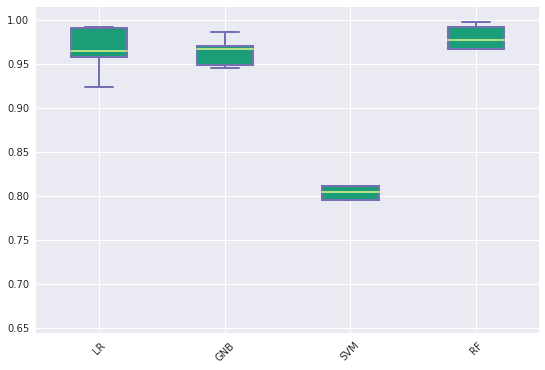

In [25]:

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(CV_score, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

ax.set_xticklabels(titles, rotation = 45)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()